# Datafonos

Uno de nuestros clientes, **CLAP**, maneja Datafonos y se encarga de procesar
pagos. **SIMETRIK** es su aliado para comparar las transacciones que se
reportan a través de sus dispositivos contra las
transacciones que se registran en las liquidaciones
bancarias (**BANSUR**).  
Cada vez que el cliente **CLAP** reporta un pago con su
datáfono envía un registro a su base de datos y a la base
de datos del adquirente **BANSUR**. Sin embargo, dada la
gran cantidad de pagos que se realizan a diario, **CLAP** no puede llevar un
control efectivo de todas las transacciones realizadas y necesitan verificar
que todas las transacciones registradas en su base de datos también se
encuentren en la base de **BANSUR**.

*IMPORTANTE:* Una transacción regular se evidencia en la base de datos
como un **PAGO**; se debe tener en cuenta que un *mismo ID* puede también
tomar estado de **Cancelación**, **Chargeback** u **Otros casos**.  
Simetrik considera una partida como conciliable toda aquella transacción
cuyo último estado en la base de datos ordenada por fecha y hora sea
PAGADA.  
Para esto, **SIMETRIK** comparará para cada transacción campos únicos entre
las dos entidades buscando encontrar parejas que sean exactamente
iguales bajo las siguientes condiciones:  
1. Que tengan el mismo **ID**.
2. Que tenga los mismos 6 primeros dígitos de la tarjeta.
3. Que tengan los mismos 4 últimos dígitos de la tarjeta.
4. Que el valor pagado en la transacción sea igual o que su diferencia
esté en el rango de más o menos 0.99 pesos.
5. Que tengan la misma fecha de transacción.

###  Importo las bibliotecas necesarias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cargo los datos de los archivos CSV en DataFrames de Pandas:

In [2]:
clap_df = pd.read_csv('data/clap.csv')
bansur_df = pd.read_csv('data/bansur.csv')

In [3]:
print(clap_df.dtypes)

INICIO6_TARJETA          float64
FINAL4_TARJETA             int64
TIPO_TRX                  object
MONTO                    float64
FECHA_TRANSACCION         object
CODIGO_AUTORIZACION       object
ID_BANCO                 float64
FECHA_RECEPCION_BANCO     object
dtype: object


In [4]:
print(bansur_df.dtypes)

TARJETA                  int64
TIPO_TRX                object
MONTO                  float64
FECHA_TRANSACCION        int64
CODIGO_AUTORIZACION     object
ID_ADQUIRIENTE           int64
FECHA_RECEPCION         object
dtype: object


In [5]:
# Revisando datos faltantes
print(clap_df.isna().sum())
print(bansur_df.isna().sum())

INICIO6_TARJETA              6
FINAL4_TARJETA               0
TIPO_TRX                     0
MONTO                        0
FECHA_TRANSACCION            0
CODIGO_AUTORIZACION      12679
ID_BANCO                    16
FECHA_RECEPCION_BANCO        0
dtype: int64
TARJETA                0
TIPO_TRX               0
MONTO                  0
FECHA_TRANSACCION      0
CODIGO_AUTORIZACION    0
ID_ADQUIRIENTE         0
FECHA_RECEPCION        0
dtype: int64


In [6]:
# Rellenar columnas 
clap_df['CODIGO_AUTORIZACION'] = clap_df['CODIGO_AUTORIZACION'].fillna(0)
clap_df['INICIO6_TARJETA'] = clap_df['INICIO6_TARJETA'].fillna(0)
clap_df['ID_BANCO'] = clap_df['ID_BANCO'].fillna(0)

In [7]:
# Asegurarme que las fechas esten en el mismo formato

# Convertir la columna 'FECHA_TRANSACCION' a objetos datetime.date
bansur_df['FECHA_TRANSACCION'] = bansur_df['FECHA_TRANSACCION'].astype(str)
bansur_df['FECHA_TRANSACCION'] = pd.to_datetime(bansur_df['FECHA_TRANSACCION'])
bansur_df['FECHA_TRANSACCION'] = bansur_df['FECHA_TRANSACCION'].dt.date

# Convertir la columna 'FECHA_RECEPCION' a objetos datetime.date
bansur_df['FECHA_RECEPCION'] = pd.to_datetime(bansur_df['FECHA_RECEPCION']).dt.date

# Convertir la columna 'FECHA_RECEPCION_BANCO' a objetos datetime.date
clap_df['FECHA_RECEPCION_BANCO'] = pd.to_datetime(clap_df['FECHA_RECEPCION_BANCO']).dt.date

# Convertir la columna 'FECHA_TRANSACCION' a objetos datetime.date
clap_df['FECHA_TRANSACCION'] = pd.to_datetime(clap_df['FECHA_TRANSACCION']).dt.date


### Conocer el monto y la cantidad de las transacciones que SIMETRIK considera como conciliables para la base de CLAP

In [8]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGADA"
conciliables_clap_df = clap_df[clap_df['TIPO_TRX'] == 'PAGADA']

In [9]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGADA"
conciliables_bansur_df = bansur_df[bansur_df['TIPO_TRX'] == 'PAGO']

In [10]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable_clap = conciliables_clap_df['MONTO'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables_clap = len(conciliables_clap_df)

print(f"Monto total de transacciones conciliables en CLAP: {monto_total_conciliable_clap}")
print(f"Cantidad de transacciones conciliables en CLAP: {cantidad_transacciones_conciliables_clap}")

Monto total de transacciones conciliables en CLAP: 61050819.40999999
Cantidad de transacciones conciliables en CLAP: 147331


### Monto y la cantidad de las transacciones que SIMETRIK considera como conciliables para la base de BANSUR


In [11]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable_bansur = conciliables_bansur_df['MONTO'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables_bansur = len(conciliables_bansur_df)

print(f"Monto total de transacciones conciliables en BANSUR: {monto_total_conciliable_bansur}")
print(f"Cantidad de transacciones conciliables en BANSUR: {cantidad_transacciones_conciliables_bansur}")

Monto total de transacciones conciliables en BANSUR: 54053911.94
Cantidad de transacciones conciliables en BANSUR: 132338


### ¿Cómo se comparan las cifras de los puntos anteriores respecto de las cifras totales en las fuentes desde un punto de vista del negocio?

### Gráficamente

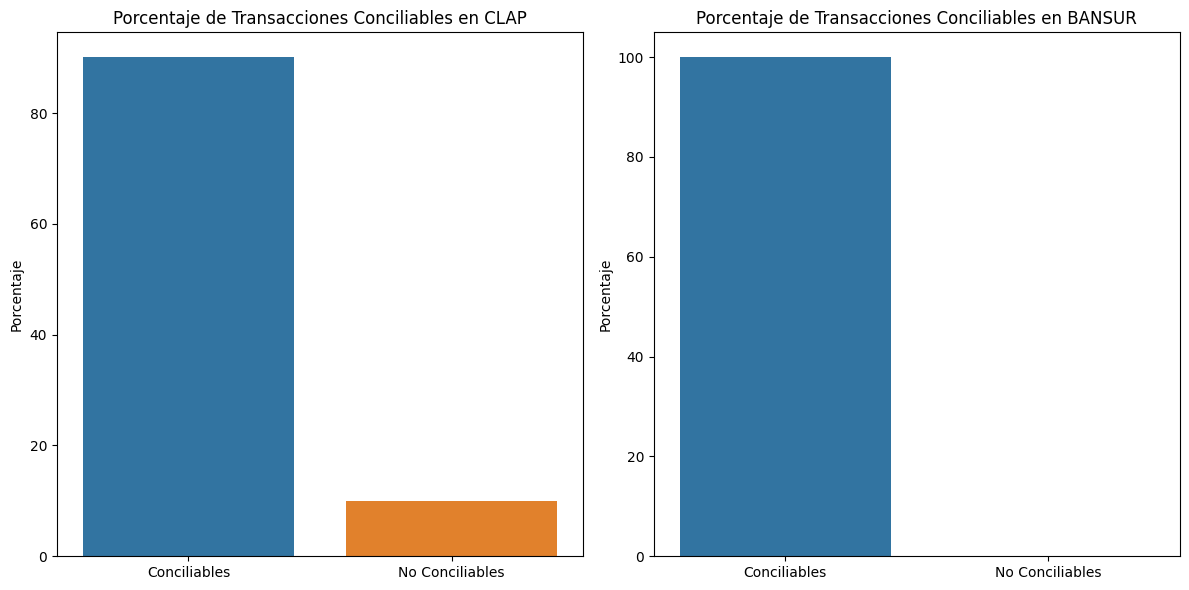

In [12]:
# Cálculos para CLAP
total_transacciones_clap = len(clap_df)
porcentaje_conciliables_clap = (cantidad_transacciones_conciliables_clap / total_transacciones_clap) * 100

# Cálculos para BANSUR
total_transacciones_bansur = len(bansur_df)
porcentaje_conciliables_bansur = (cantidad_transacciones_conciliables_bansur / total_transacciones_bansur) * 100


# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graficar el porcentaje de transacciones conciliables en CLAP
sns.barplot(x=['Conciliables', 'No Conciliables'], y=[porcentaje_conciliables_clap, 100 - porcentaje_conciliables_clap], ax=axes[0])
axes[0].set_title('Porcentaje de Transacciones Conciliables en CLAP')
axes[0].set_ylabel('Porcentaje')

# Graficar el porcentaje de transacciones conciliables en BANSUR
sns.barplot(x=['Conciliables', 'No Conciliables'], y=[porcentaje_conciliables_bansur, 100 - porcentaje_conciliables_bansur], ax=axes[1])
axes[1].set_title('Porcentaje de Transacciones Conciliables en BANSUR')
axes[1].set_ylabel('Porcentaje')

plt.tight_layout()
plt.show()

In [38]:
print(f"Total transacciones en CLAP: {total_transacciones_clap}")
print(f"Total transacciones en BANSUR: {total_transacciones_bansur}")

print(f"Cantidad transacciones conciliables en CLAP: {cantidad_transacciones_conciliables_clap}")
print(f"Cantidad transacciones conciliables en BANSUR: {cantidad_transacciones_conciliables_bansur}")

print(f"Porcentaje de transacciones conciliables en CLAP: {porcentaje_conciliables_clap:.2f}%")
print(f"Porcentaje de transacciones conciliables en BANSUR: {porcentaje_conciliables_bansur:.2f}%")

Total transacciones en CLAP: 163549
Total transacciones en BANSUR: 132396
Cantidad transacciones conciliables en CLAP: 147331
Cantidad transacciones conciliables en BANSUR: 132338
Porcentaje de transacciones conciliables en CLAP: 90.08%
Porcentaje de transacciones conciliables en BANSUR: 99.96%


Desde un punto de vista del negocio, al comparar las cifras de los puntos anteriores con las cifras totales en las fuentes, podemos obtener información valiosa sobre el proceso de conciliación entre CLAP y BANSUR. Es importante resaltar que una transacción regular en las bases de datos se refleja como un PAGO, considerando también la posibilidad de que un mismo ID pueda tener diferentes estados como Cancelación, Chargeback u Otros casos.

En el análisis realizado, hemos identificado que:

En la base de CLAP, el 90.08% de las transacciones son consideradas como conciliables, es decir, cumplen con las condiciones de comparación establecidas. Esto significa que la mayoría de las transacciones registradas por CLAP se ajustan a las condiciones requeridas para considerarse correctamente conciliadas con BANSUR.

Por otro lado, en la base de BANSUR, el 99.96% de las transacciones son consideradas como conciliables. Esto indica un alto grado de conciliación en BANSUR, donde la gran mayoría de las transacciones registradas cumplen con las condiciones establecidas para ser consideradas conciliables.

Estos resultados pueden tener implicaciones significativas en la eficacia de los procesos de registro y conciliación entre ambas bases. La diferencia en el porcentaje de transacciones conciliables entre CLAP y BANSUR podría sugerir que BANSUR está registrando una proporción mucho mayor de transacciones conciliables, lo que podría indicar una mayor precisión en su proceso de registro o conciliación.

En general, estos hallazgos proporcionan una visión más clara de cómo se comparan las cifras de transacciones conciliables entre las fuentes y cómo estos porcentajes se alinean con los objetivos de conciliación y calidad de los datos en el contexto del negocio.

### Teniendo en cuenta los criterios de cruce entre ambas bases conciliables:
1. Que tengan el mismo **ID** (ID_ADQUIRIENTE = ID_BANCO).
2. Que tenga los mismos 6 primeros dígitos de la tarjeta (resuelvo al crear un campo adicional TARJETA EN conciliables_clap_df).
3. Que tengan los mismos 4 últimos dígitos de la tarjeta.
4. Que el valor pagado en la transacción sea igual o que su diferencia
esté en el rango de más o menos 0.99 pesos.
5. Que tengan la misma fecha de transacción.

### Vamos a obtener un dataframe que contenga la información de CLAP y BANSUR con todas la transacciones que se cruzaron

In [41]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGADA"
clap_df = clap_df[clap_df['TIPO_TRX'] == 'PAGADA']

In [42]:
print(len(clap_df))

147331


In [40]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGO"
bansur_df = bansur_df[bansur_df['TIPO_TRX'] == 'PAGO']

In [39]:
print(len(bansur_df))

132338


In [17]:
# Convertir columnas a tipos de datos compatibles
clap_df['INICIO6_TARJETA'] = clap_df['INICIO6_TARJETA'].astype(int).astype(str)
clap_df['FINAL4_TARJETA'] = clap_df['FINAL4_TARJETA'].astype(str)
bansur_df['TARJETA'] = bansur_df['TARJETA'].astype(str)

In [18]:
# Convertir 'ID_BANCO' a int64
clap_df['ID_BANCO'] = clap_df['ID_BANCO'].astype('int64') 

In [19]:
print(clap_df.head())

  INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX   MONTO FECHA_TRANSACCION  \
1          802414           6615   PAGADA   42.51        2020-11-01   
3          954015           5581   PAGADA   41.00        2020-11-01   
4          954015           2538   PAGADA   68.00        2020-11-01   
5          954015           2581   PAGADA  144.00        2020-11-01   
6          818156           8094   PAGADA  189.50        2020-11-01   

  CODIGO_AUTORIZACION      ID_BANCO FECHA_RECEPCION_BANCO  
1              053042   29607730901            2020-11-02  
3              013616  441622557487            2020-11-02  
4              013602  266554946896            2020-11-02  
5              013626  106967585923            2020-11-02  
6              053064  890554602678            2020-11-02  


In [20]:
print(clap_df.dtypes)

INICIO6_TARJETA           object
FINAL4_TARJETA            object
TIPO_TRX                  object
MONTO                    float64
FECHA_TRANSACCION         object
CODIGO_AUTORIZACION       object
ID_BANCO                   int64
FECHA_RECEPCION_BANCO     object
dtype: object


In [21]:
print(bansur_df.head())

      TARJETA TIPO_TRX   MONTO FECHA_TRANSACCION CODIGO_AUTORIZACION  \
0  9540150300     PAGO    44.0        2020-11-01              272012   
1  9540150300     PAGO    93.0        2020-11-01              216149   
2  9540150310     PAGO  1579.0        2020-11-01              898544   
3  9540150319     PAGO    86.0        2020-11-01              501928   
4  9540150314     PAGO   679.0        2020-11-01              170207   

   ID_ADQUIRIENTE FECHA_RECEPCION  
0    320720237226      2020-11-03  
1    812801092295      2020-11-03  
2    563080775636      2020-11-03  
3    924685088703      2020-11-03  
4     35452614774      2020-11-03  


In [22]:
print(bansur_df.dtypes)

TARJETA                 object
TIPO_TRX                object
MONTO                  float64
FECHA_TRANSACCION       object
CODIGO_AUTORIZACION     object
ID_ADQUIRIENTE           int64
FECHA_RECEPCION         object
dtype: object


In [23]:
# Creo un nuevo campo TARJETA (INICIO6_TARJETA + FINAL4_TARJETA) en clap_df

clap_df['TARJETA'] = clap_df['INICIO6_TARJETA'] + clap_df['FINAL4_TARJETA']

In [24]:
print(clap_df)

       INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX    MONTO FECHA_TRANSACCION  \
1               802414           6615   PAGADA    42.51        2020-11-01   
3               954015           5581   PAGADA    41.00        2020-11-01   
4               954015           2538   PAGADA    68.00        2020-11-01   
5               954015           2581   PAGADA   144.00        2020-11-01   
6               818156           8094   PAGADA   189.50        2020-11-01   
...                ...            ...      ...      ...               ...   
163541          954015           4142   PAGADA   201.00        2020-11-01   
163542          905158           9023   PAGADA  1067.00        2020-11-01   
163543          922059           9467   PAGADA  2243.00        2020-11-01   
163544          954015           9059   PAGADA   128.00        2020-11-01   
163545          404826           5173   PAGADA   416.88        2020-11-01   

       CODIGO_AUTORIZACION      ID_BANCO FECHA_RECEPCION_BANCO     TARJETA 

In [25]:
print(bansur_df)

           TARJETA TIPO_TRX    MONTO FECHA_TRANSACCION CODIGO_AUTORIZACION  \
0       9540150300     PAGO     44.0        2020-11-01              272012   
1       9540150300     PAGO     93.0        2020-11-01              216149   
2       9540150310     PAGO   1579.0        2020-11-01              898544   
3       9540150319     PAGO     86.0        2020-11-01              501928   
4       9540150314     PAGO    679.0        2020-11-01              170207   
...            ...      ...      ...               ...                 ...   
132391  4450167626     PAGO    350.0        2020-11-01              149593   
132392  4427328952     PAGO   5000.0        2020-11-01              053891   
132393  4427537641     PAGO   5000.0        2020-11-01              042185   
132394  4461382609     PAGO  17500.0        2020-11-01              755434   
132395  4461382609     PAGO  50000.0        2020-11-01              751564   

        ID_ADQUIRIENTE FECHA_RECEPCION  
0         320720237226

 **Unir los dos DataFrames**    
 en función de los campos de identificación (ID_BANCO y ID_ADQUIRIENTE) utilizando el método merge() de pandas. Esto creará un nuevo DataFrame que contiene registros que tienen el mismo ID.

In [26]:
# Renombrar columna para que coincidan los nombres
bansur_df.rename(columns={'ID_ADQUIRIENTE': 'ID_BANCO'}, inplace=True)

In [27]:
merged_df = clap_df.merge(bansur_df, on='ID_BANCO', suffixes=('_clap', '_bansur'))

Filtrado por Números de TARJETA

In [28]:
merged_df = merged_df[merged_df['TARJETA_clap'] == merged_df['TARJETA_bansur']]

Filtrado por Valor Pagado

In [29]:
merged_df = merged_df[abs(merged_df['MONTO_clap'] - merged_df['MONTO_bansur']) <= 0.99]

Filtrado por FECHA_TRANSACCION

In [30]:
merged_df = merged_df[merged_df['FECHA_TRANSACCION_clap'] == merged_df['FECHA_TRANSACCION_bansur']]

Resultados: 

In [31]:
print(merged_df)

      INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX_clap  MONTO_clap  \
1              954015           6530        PAGADA       130.0   
2              497797           2844        PAGADA      2100.0   
3              958758           1814        PAGADA       119.0   
4              404826           6379        PAGADA       450.0   
5              404826           7275        PAGADA        27.0   
...               ...            ...           ...         ...   
96351          975421           8273        PAGADA       128.0   
96352          954015           4112        PAGADA       119.0   
96353          954015           5624        PAGADA        70.0   
96354          958758           5464        PAGADA        52.0   
96356          908632           7560        PAGADA       138.0   

      FECHA_TRANSACCION_clap CODIGO_AUTORIZACION_clap      ID_BANCO  \
1                 2020-11-01                   193429   41467739202   
2                 2020-11-01                   127882   748784463

In [32]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable = merged_df['MONTO_clap'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables = len(merged_df)

print(f"Monto total de transacciones conciliables: {monto_total_conciliable}")
print(f"Cantidad de transacciones conciliables: {cantidad_transacciones_conciliables}")

Monto total de transacciones conciliables: 37066867.56999999
Cantidad de transacciones conciliables: 86796


En el siguiente código, utilizo 'ID_BANCO' como base para identificar las transacciones en clap_df y bansur_df que no están en merged_df. Luego, creamos DataFrames separados para estas transacciones no cruzadas.

In [46]:
# Identificar los registros en clap_df que no están en merged_df
no_cruzados_clap_df = clap_df[~clap_df.set_index(['ID_BANCO']).index.isin(merged_df.set_index(['ID_BANCO']).index)].copy()

# Identificar los registros en bansur_df que no están en merged_df
no_cruzados_bansur_df = bansur_df[~bansur_df.set_index(['ID_BANCO']).index.isin(merged_df.set_index(['ID_BANCO']).index)].copy()



Así, obtenemos los DataFrames no_cruzados_clap_df y no_cruzados_bansur_df que contienen las transacciones que no cruzaron.

In [47]:
print(len(no_cruzados_clap_df))

60535


In [50]:
print(no_cruzados_clap_df)

       INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX    MONTO FECHA_TRANSACCION  \
1               802414           6615   PAGADA    42.51        2020-11-01   
3               954015           5581   PAGADA    41.00        2020-11-01   
4               954015           2538   PAGADA    68.00        2020-11-01   
5               954015           2581   PAGADA   144.00        2020-11-01   
6               818156           8094   PAGADA   189.50        2020-11-01   
...                ...            ...      ...      ...               ...   
163541          954015           4142   PAGADA   201.00        2020-11-01   
163542          905158           9023   PAGADA  1067.00        2020-11-01   
163543          922059           9467   PAGADA  2243.00        2020-11-01   
163544          954015           9059   PAGADA   128.00        2020-11-01   
163545          404826           5173   PAGADA   416.88        2020-11-01   

       CODIGO_AUTORIZACION      ID_BANCO FECHA_RECEPCION_BANCO     TARJETA 

In [48]:
print(len(no_cruzados_bansur_df))

45542


In [51]:
print(no_cruzados_bansur_df)

           TARJETA TIPO_TRX     MONTO FECHA_TRANSACCION CODIGO_AUTORIZACION  \
0       9540150300     PAGO     44.00        2020-11-01              272012   
1       9540150300     PAGO     93.00        2020-11-01              216149   
2       9540150310     PAGO   1579.00        2020-11-01              898544   
3       9540150319     PAGO     86.00        2020-11-01              501928   
4       9540150314     PAGO    679.00        2020-11-01              170207   
...            ...      ...       ...               ...                 ...   
132360  4923290301     PAGO    253.39        2020-11-01              463174   
132367  9540151814     PAGO     75.00        2020-11-01              232583   
132376  9853980067     PAGO    350.00        2020-11-01              020719   
132380  9754881474     PAGO    350.00        2020-11-01              000076   
132394  4461382609     PAGO  17500.00        2020-11-01              755434   

            ID_BANCO FECHA_RECEPCION  
0       3207

### Porcentaje de transacciones de la base conciliable de CLAP que cruzó contra la liquidación de BANSUR

In [53]:
# Cálculos para CLAP
total_conciliables_clap = len(clap_df)
porcentaje_cruzadas_clap = (len(merged_df) / total_conciliables_clap) * 100

# Cálculos para BANSUR
total_conciliables_bansur = len(bansur_df)
porcentaje_cruzadas_bansur = (len(merged_df) / total_conciliables_bansur) * 100

print(f"Porcentaje de transacciones cruzadas en CLAP: {porcentaje_cruzadas_clap:.2f}%")
print(f"Porcentaje de transacciones cruzadas en BANSUR: {porcentaje_cruzadas_bansur:.2f}%")

Porcentaje de transacciones cruzadas en CLAP: 58.91%
Porcentaje de transacciones cruzadas en BANSUR: 65.59%


### Porcentaje de transacciones de la base conciliable de BANSUR no cruzó contra la liquidación de CLAP.

In [55]:
# Cálculos para BANSUR
total_conciliables_bansur = len(bansur_df)
porcentaje_no_cruzadas_bansur = (len(no_cruzados_bansur_df)  / total_conciliables_bansur) * 100

# Cálculos para CLAP
total_conciliables_clap = len(clap_df)
porcentaje_no_cruzadas_clap = (len(no_cruzados_clap_df)  / total_conciliables_clap) * 100

print(f"Porcentaje de transacciones No cruzadas en BANSUR: {porcentaje_no_cruzadas_bansur:.2f}%")
print(f"Porcentaje de transacciones No cruzadas en CLAP: {porcentaje_no_cruzadas_clap:.2f}%")

Porcentaje de transacciones No cruzadas en BANSUR: 34.41%
Porcentaje de transacciones No cruzadas en CLAP: 41.09%


Gráficamente

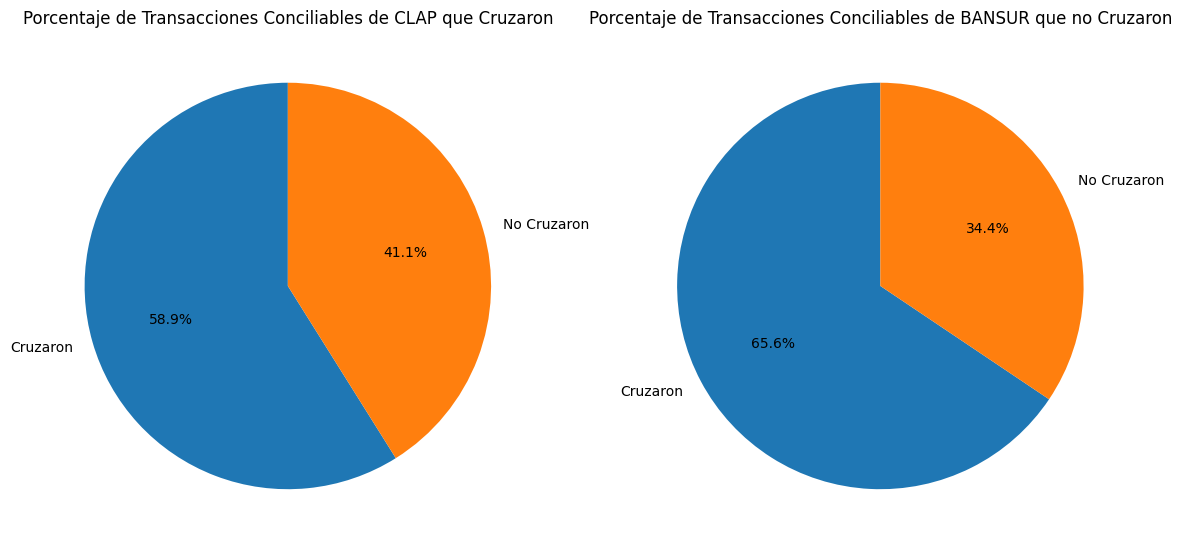

In [56]:
import matplotlib.pyplot as plt

# Datos para el gráfico circular
labels = ['Cruzaron', 'No Cruzaron']
sizes_clap = [porcentaje_cruzadas_clap, 100 - porcentaje_cruzadas_clap]
sizes_bansur = [100 - porcentaje_no_cruzadas_bansur, porcentaje_no_cruzadas_bansur]

# Crear el gráfico circular
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(sizes_clap, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Porcentaje de Transacciones Conciliables de CLAP que Cruzaron')

ax2.pie(sizes_bansur, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Porcentaje de Transacciones Conciliables de BANSUR que no Cruzaron')

plt.tight_layout()
plt.show()
